# Kaggle - 집값 맟추기

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


### column_name

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [5]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


모델을 학습시키기 전에, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat으로 합쳐봅니다.

In [6]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [7]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<AxesSubplot:>

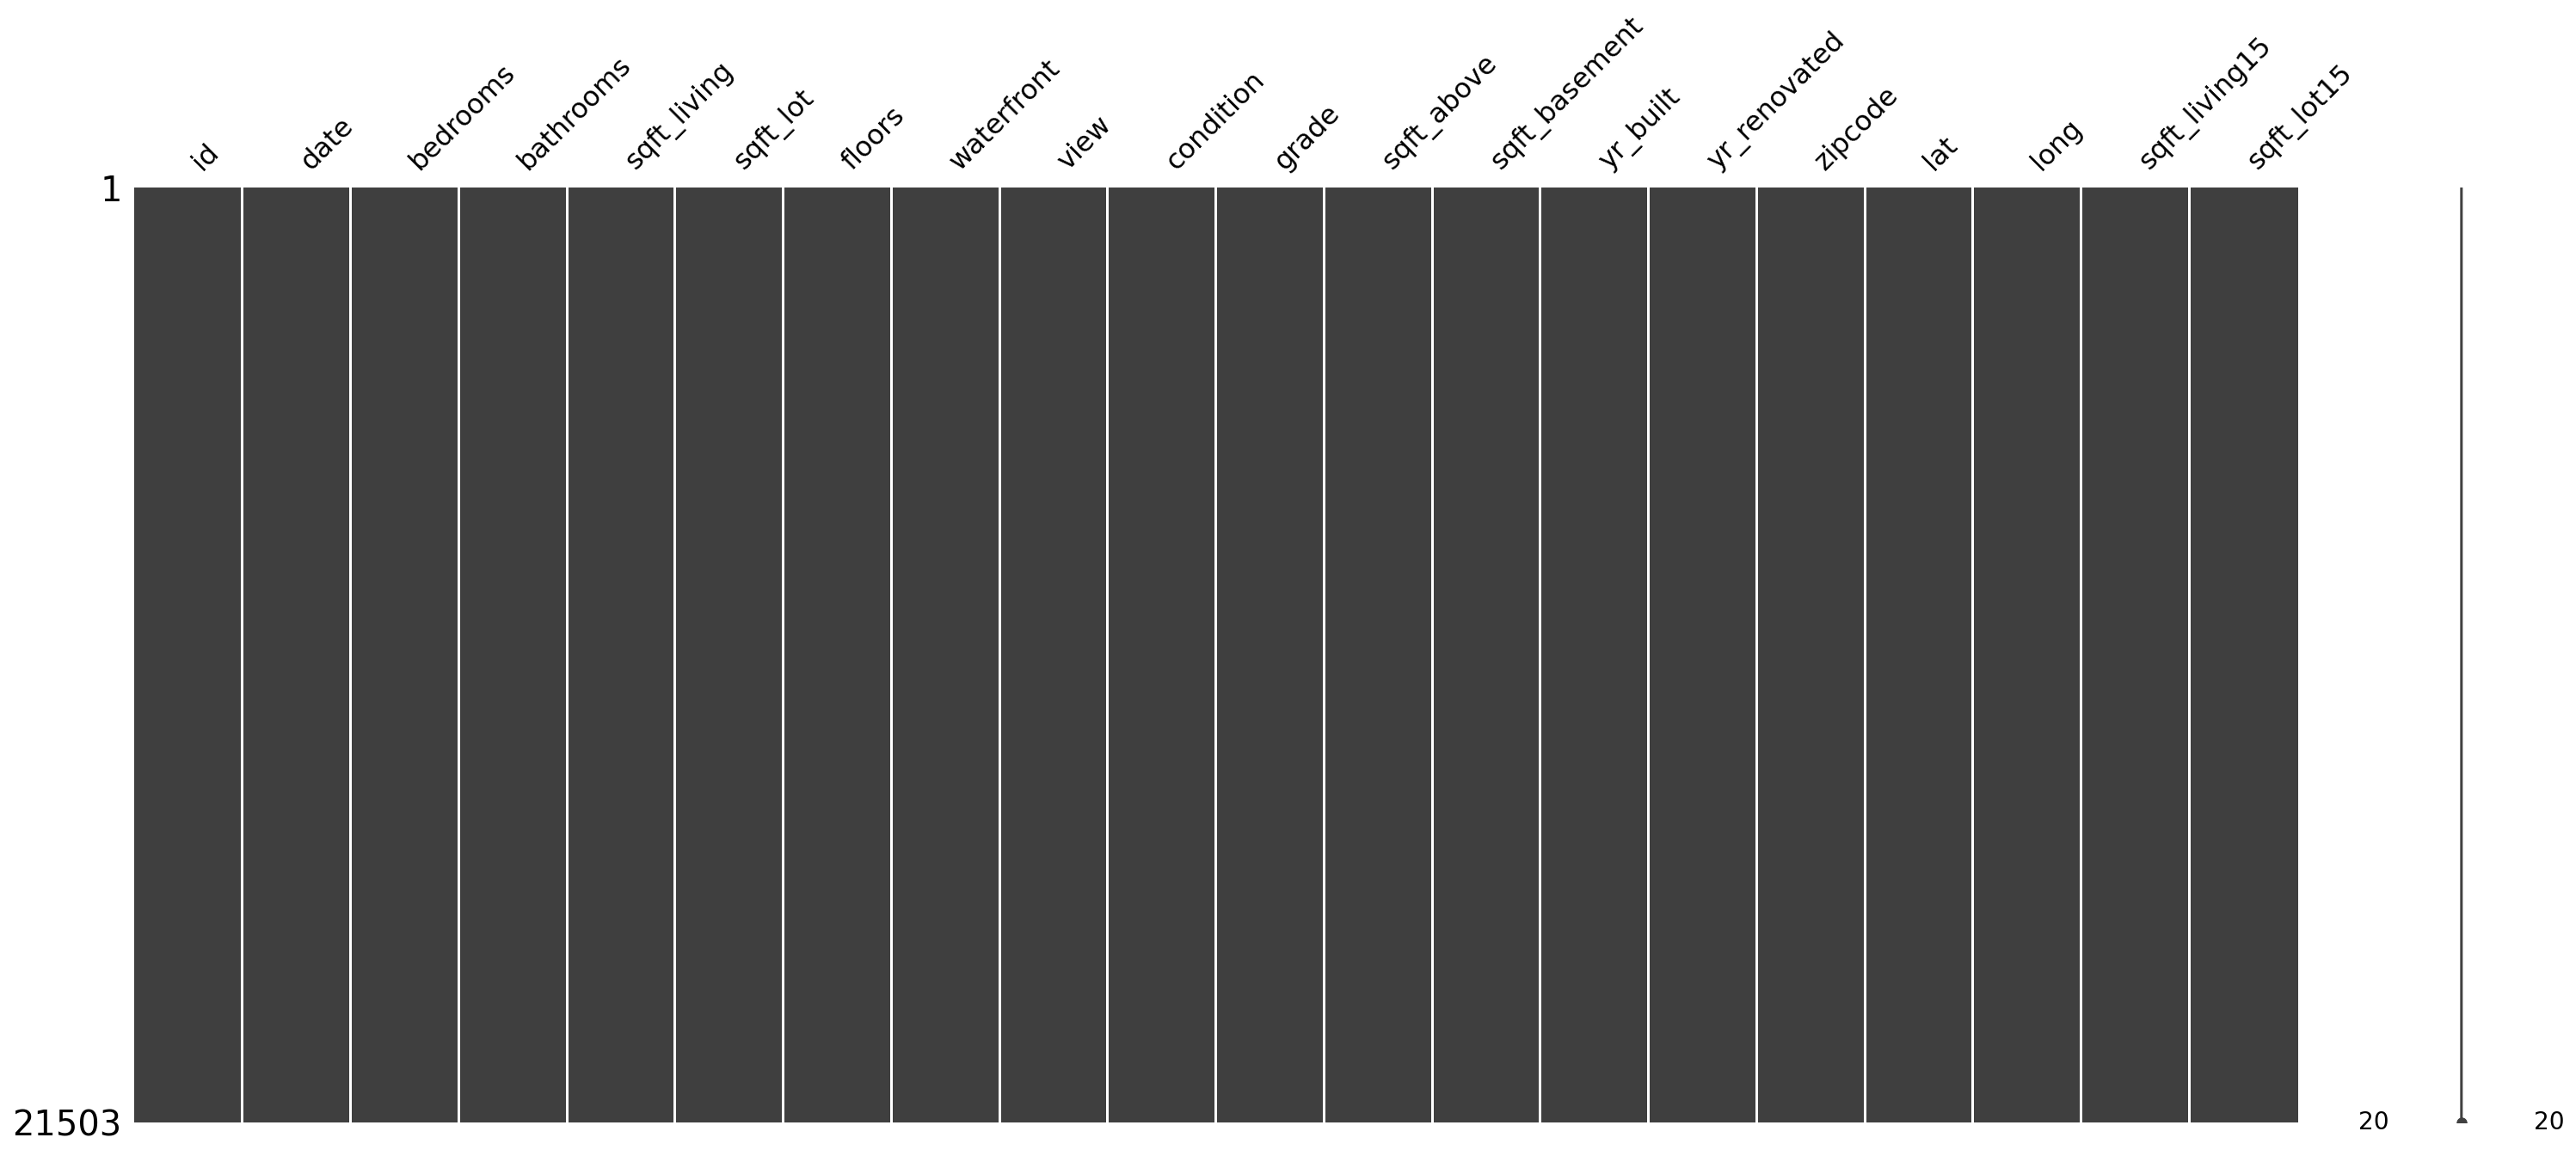

In [8]:
msno.matrix(data)

- id 컬럼이 결측치인지 확인합니다.

In [9]:
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


- True와 False로 이루어진 데이터프레임이 출력된다는 점 기억해야 합니다.

- 결측치인 데이터만 뽑아냅니다.

In [10]:
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

- 결측치인 데이터의 개수를 셉니다.

In [11]:
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [12]:
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


In [13]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


필요 없는 id 컬럼을 제거합니다. 나중에 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id 칼럼을 저장해두고 지우도록 하겠습니다.

In [14]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [15]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- str(x[:6]) 으로 처리한 것은 20141013T000000 형식의 데이터를 연/월 데이터만 사용하기 위해 201410까지 자르기 위한 것입니다.

- 10행 2열의 subplot에 그래프를 그리기 위해 2중 for문을 사용했습니다.

그래프의 종류는 sns.kdeplot을 사용합니다.
kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수입니다.

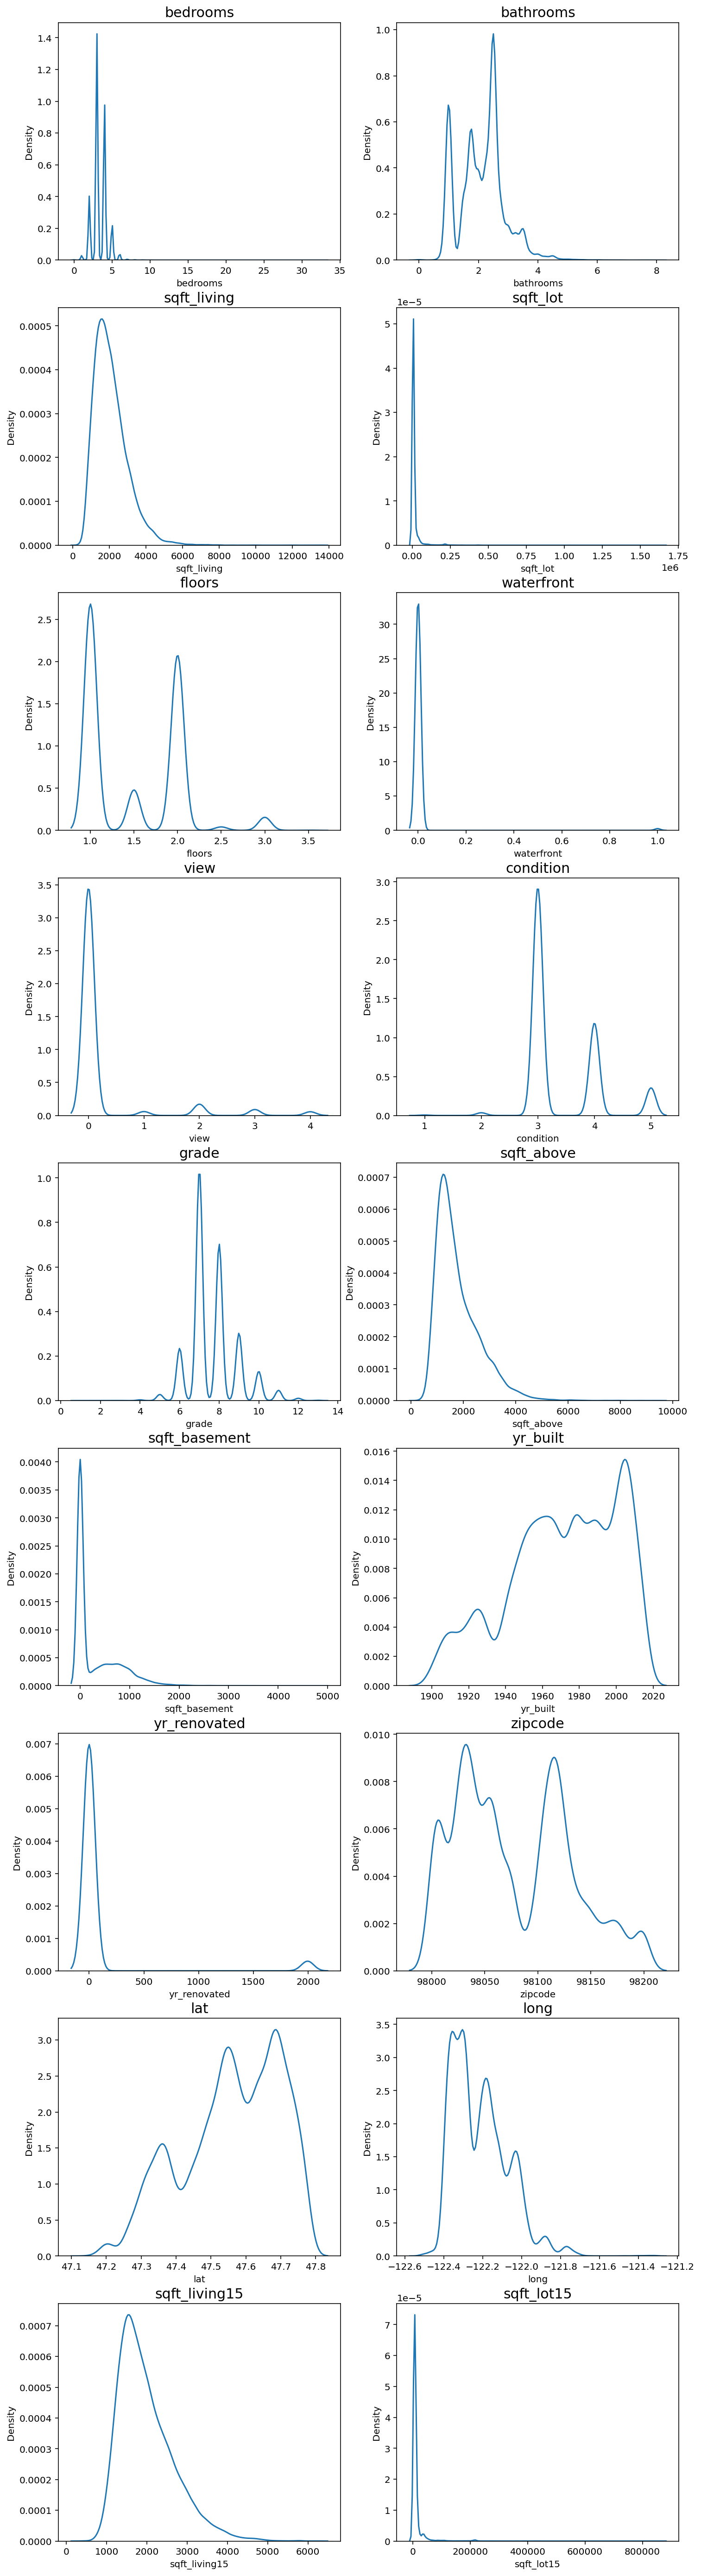

In [16]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [17]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

얍💢


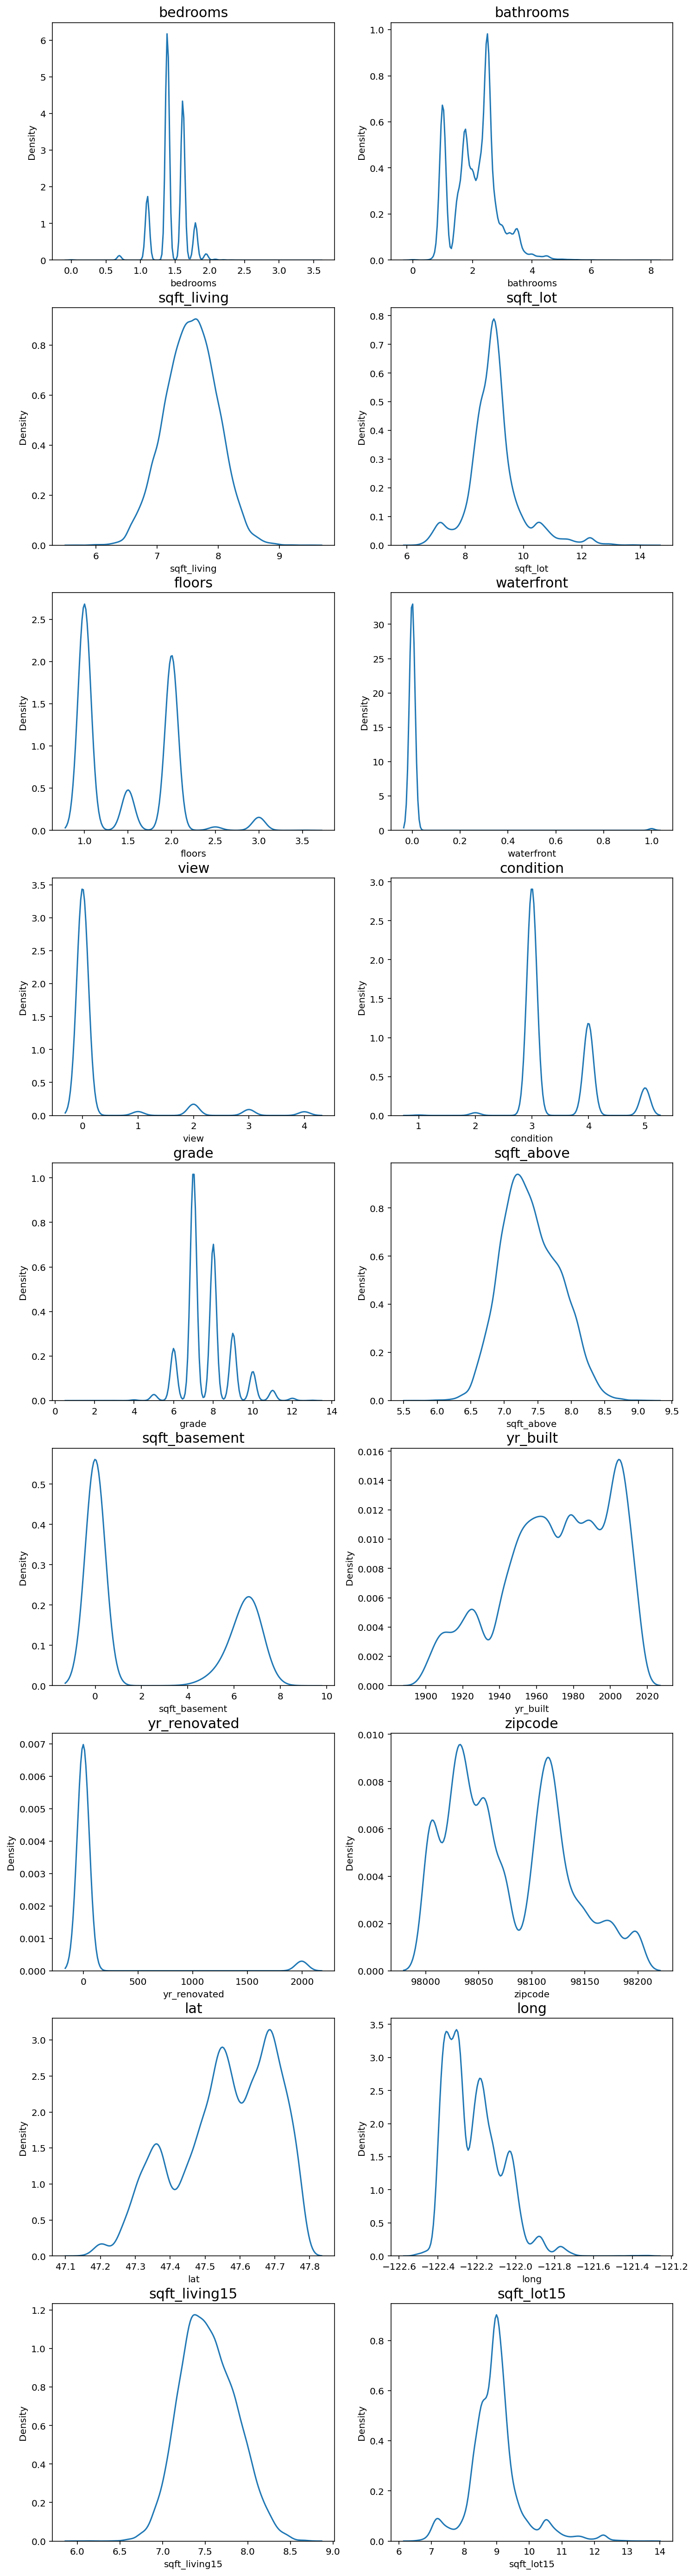

In [18]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

- 이전보다 훨씬 치우침이 줄어든 분포를 확인할 수 있습니다.

### 그렇다면 왜 로그 변환은 분포의 치우침을 줄어들게 만드는 걸까요?


- 이는 로그 함수의 형태를 보면 알 수 있습니다. 아래의 일반적인 로그 함수를 살펴봅시다.



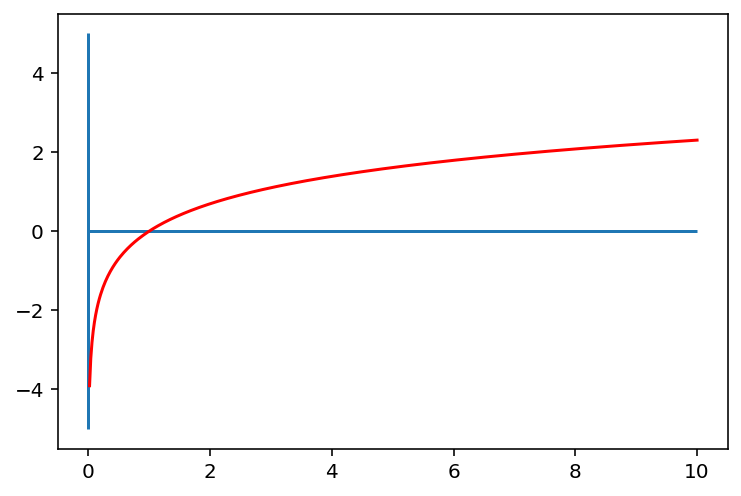

In [19]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

- 0<x<1 범위에서는 기울기가 매우 가파릅니다. 즉, xx의 구간은 (0, 1)(0,1)로 매우 짧은 반면, yy의 구간은 (-\infty, 0)(−∞,0)으로 매우 큽니다.


- 따라서 0에 가깝게 모여있는 값들이 xx로 입력되면, 그 함수값인 yy 값들은 매우 큰 범위로 벌어지게 됩니다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가집니다.


- 반면, xx값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아집니다. 이는 곧 큰 xx값들에 대해서는 yy값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 xx를 비교적 작은 yy값의 구간 내에 모이게 하는 특징을 가집니다.

그렇다면 우리가 맞추어야 할 타겟인 집의 가격, 즉 data[price]의 분포를 로그 변환했을 때 결과를 유추해봅시다.
원래 price의 분포는 다음과 같습니다.

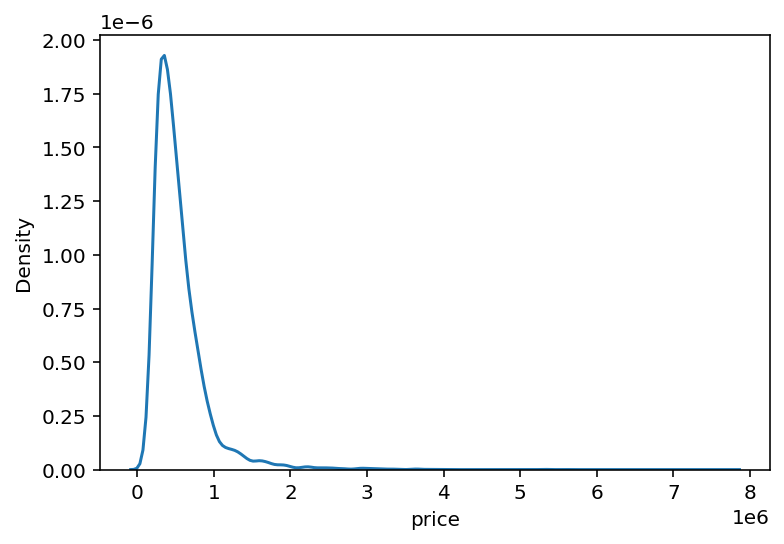

In [20]:
sns.kdeplot(y)
plt.show()

- 위에서 저장해두었던 train_len을 인덱스로 활용해서 :train_len까지는 학습 데이터, 즉 x에 저장하고, train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장합니다

In [21]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## 모델링

- 이제 본격적으로 학습시킬 모델을 준비합니다. Baseline 커널에서는 여러 가지 모델을 함께 사용해서 결과를 섞는, 블렌딩(blending) 이라는 기법을 활용합니다.


- 블렌딩이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법입니다.


- 블렌딩은 앙상블 기법이라고 하기도 하는데요, 자세한 내용을 다음 포스팅에서 살짝 읽어보겠습니다.

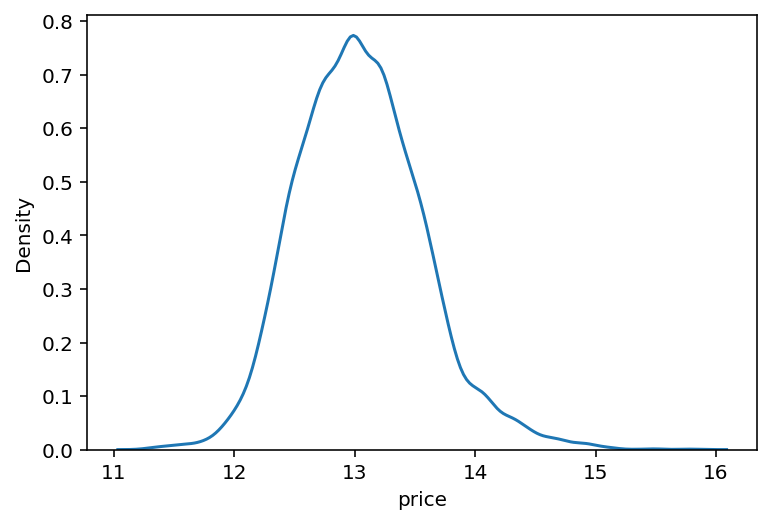

In [22]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

- 그러면 여기까지 로그 변환이 필요한 데이터에 대해 처리를 마무리하였으니, 아래와 같이 전체 데이터를 다시 나누어 줍니다.

- 위에서 저장해두었던 train_len을 인덱스로 활용해서 :train_len까지는 학습 데이터, 즉 x에 저장하고, train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장합니다.

In [23]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


### 앙상블(Ensemble) 

- 앙상블(Ensemble)학습은 여러 개의 학습 알고리즘을 사용하고, 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법입니다.


- 하나의 강한 머신러닝 알고리즘보다 여러 개의 약한 머신러닝 알고리즘이 낫다는 아이디어로부터 시작되었습니다.

### 앙상블 기법 중 가장 기본적인 것은 보팅(Voting)과 에버리징(Averaging) 입니다. 

- 이둘은 서로 다른 알고리즘을 가진 분류기를 결합하는 방식입니다.


- Voting은 여러 모델이 분류해 낸 결과들로부터 말 그대로 다수결 투표를 통해 최종 결과를 선택하는 방법으로, 분류 문제에서 사용됩니다.


- Averaging은 각 모델이 계산해 낸 실숫값들을 평균 혹은 가중평균하여 사용하는 방법으로, 회귀 문제에서 사용됩니다.

In [24]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [25]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

얍💢


In [26]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


In [27]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [28]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [29]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [30]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [31]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


In [32]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [33]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [34]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [35]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- id 컬럼을 삭제하는 것까지 하면 기본적인 전처리는 모두 마무리됩니다.

In [36]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [37]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


타겟 데이터인 y를 한번 확인해 보겠습니다.

In [38]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

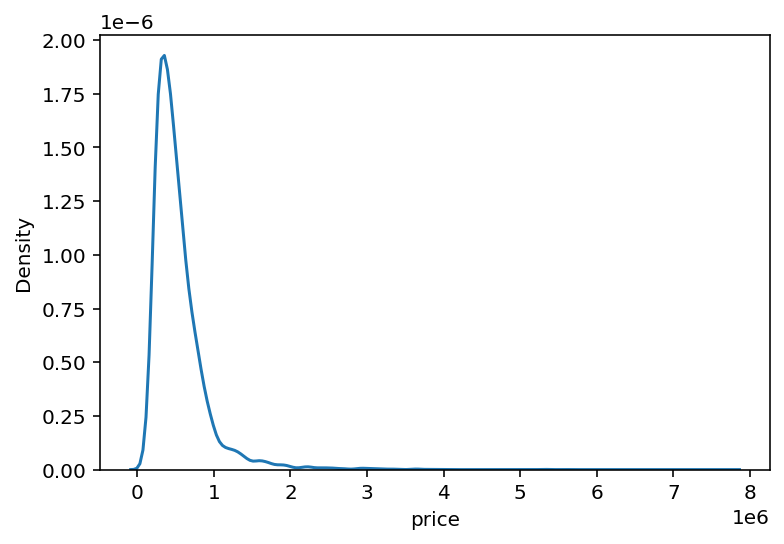

In [39]:
sns.kdeplot(y)
plt.show()

In [40]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

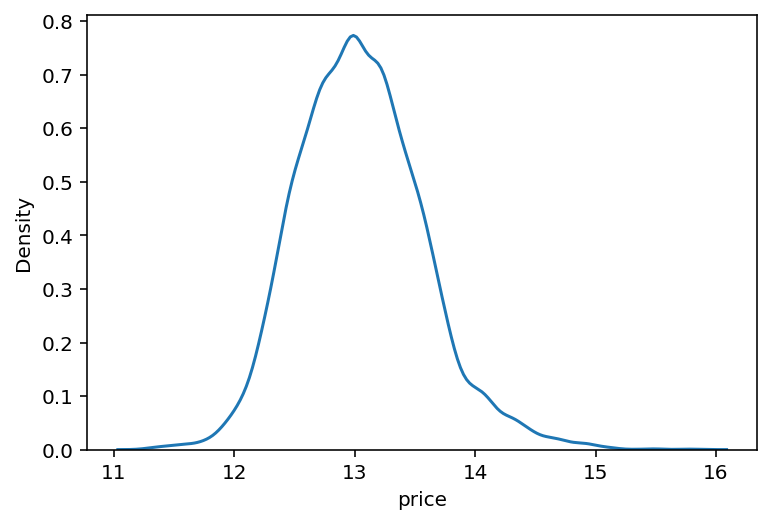

In [41]:
sns.kdeplot(y)
plt.show()

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


In [44]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [45]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [46]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [47]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [48]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [49]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [50]:
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


#### GridSearchCV란 무엇일까요?

우선 그리드 탐색과 랜덤 탐색을 알아볼 필요가 있습니다. 두 가지 모두 하이퍼 파라미터를 조합해 보는 방법입니다.

그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색합니다. 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리하겠네요!

랜덤 탐색은 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법입니다.

다음 이미지가 그리드 탐색(grid search)과 랜덤 탐색(random search) 두 가지를 잘 나타내고 있습니다.
그리드 탐색은 정해진 하이퍼 파라미터의 조합을 격자와 같이 탐색하는 반면, 랜덤 탐색은 랜덤으로 점을 찍어서 탐색합니다.

확실히 그리드 탐색의 탐색 공간은 매우 제한적인 반면 랜덤 탐색은 탐색하는 공간이 훨씬 넓습니다.
![title](https://d3s0tskafalll9.cloudfront.net/media/images/E10-13.max-800x600.png)



 앞서 언급했듯 다양한 파라미터를 입력하면 가능한 모든 조합을 탐색하는 사이킷런의 GridSearchCV를 활용해 볼 것입니다.

먼저 GridSearchCV에 입력되는 인자들은 다음과 같습니다.

- para m_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)


- scoring : 모델의 성능을 평가할 지표


- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수


- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)


- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

그러면 param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비합니다.

In [67]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
print('얍💢')

얍💢


In [68]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}
param_grid

{'n_estimators': [50, 100], 'max_depth': [1, 10]}

In [71]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [72]:
grid_model.cv_results_

{'mean_fit_time': array([0.2276484 , 0.21504059, 0.48300672, 0.80908747]),
 'std_fit_time': array([0.07684303, 0.0052825 , 0.13015097, 0.13088132]),
 'mean_score_time': array([0.019631  , 0.02125831, 0.02872696, 0.05098467]),
 'std_score_time': array([0.01713437, 0.01101807, 0.00971213, 0.01695347]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

정보가 너무 많아서 눈에 잘 들어오지 않는군요. 우리는 원하는 값만 정제해서 확인하도록 하겠습니다.

우리가 관심 있는 정보는 어떤 파라미터 조합일 때 점수가 어떻게 나오게 되는지에 관한 것이겠죠.
파라미터 조합은 위 딕셔너리 중 params에, 각각에 대한 테스트 점수는 mean_test_score에 저장되어 있습니다.

In [73]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [74]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

params에는 각 파라미터의 조합이, score에는 각 조합에 대한 점수가 들어가 있군요.

이제 이 둘만 가지고 데이터 프레임을 만들고 최적의 성능을 내는 하이퍼 파라미터의 조합을 찾아봅시다.

다음과 같은 형태의 데이터 프레임을 출력하는 코드를 작성해 보세요.

![title](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-10-14.png)

In [76]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


#### ※참고 GridSearchCV에서 모델을 초기화할 때 scoring 인자에는MSE에 음수를 취한 값인 neg_mean_squared_error를 입력해 점수가 음수가 나옵니다.

In [77]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


 - 하지만 아직도 위에서 보았던 10만 단위의 RMSE와는 값의 크기가 아주 다른 것 같습니다.

그 이유는 price에 있습니다. 위에서 우리는 price의 분포가 한쪽으로 치우쳐져 있는 것을 보고 log 변환을 했었죠.
그 후 RMSE 값을 계산하기 위한 함수에서는 np.expm1 함수를 활용해 다시 원래대로 복원한 후 RMSE 값을 계산했습니다.

하지만 그리드 탐색을 하면서는 np.expm1()으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 price 데이터에서 손실함수값을 계산한 것이죠.
따라서 사실, 위의 데이터 프레임에 나타난 값은 정확히 말하면 RMSE가 아니라 RMSLE, 즉 Root Mean Squared Log Error 입니다.
log를 취한 값에서 RMSE를 구했다는 뜻이죠!

이에 맞게 컬럼의 이름을 RMSLE로 변환해 주도록 하겠습니다. 판다스에서 컬럼의 이름 변환은 rename으로 할 수 있습니다.

In [78]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [79]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [80]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [81]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    3.9s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [82]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [83]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [84]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [85]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [86]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [87]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [88]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


#### 튜닝해볼 수 있는 모델 클래스 인자

- max_depth : 의사 결정 나무의 깊이, 정수 사용


- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용


- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용


- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수


- boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

#### ✓ 시도해볼 수 있는 방법

시도해볼 수 있는 방법은 다음과 같은 것들이 있습니다.

- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)


- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기


- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기


- Baseline 커널에서 활용했던 블렌딩 방법 활용하기






아주 다양하게 데이터를 탐색해 본 커널도 있고, 상위권을 달성한 커널은 오늘 다루지 않은 스태킹 앙상블(stacking ensemble) 등의 기법을 활용한 커널을 활용하기도 합니다. 한 번씩 구경해보고 다른 사람들은 어떤 전략으로 성능을 끌어올렸는지 공부해보는 것도 매우 좋을 겁니다!

![title](![%EC%A0%90%EC%88%98.png](attachment:%EC%A0%90%EC%88%98.png))